# Health Data Scientist Practical Assessment

**Candidate:** Cameron Hannie  
**Date:** 16 February 2026

## Section B  Practical: Wide Patient Dataset
### Imports :


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import date




## 1) Load the data files
We load the medicine dispensing data and the laboratory data and do basic data analysis checks.  


In [65]:
med = pd.read_csv("medicine_data.csv")
med.head()

,patient_id,sex,date_of_birth,medication_name,dispensing_date
0,8269196,F,1964/04/19,insulin,2019/01/01
1,8269196,F,1964/04/19,insulin,2019/02/14
2,8269196,F,1964/04/19,insulin,2019/03/11
3,8269196,F,1964/04/19,insulin,2019/04/01
4,8269196,F,1964/04/19,insulin,2019/05/20


In [66]:
lab = pd.read_csv("lab_data.txt", sep="\t")
lab.head()

,patient_id,sex,date_of_birth,lab_test_type,lab_test_date,lab_test_result
0,5232214,Male,1952/04/11,HbA1c,2019/03/09,8.4
1,5632991,Female,1945/10/09,HbA1c,2019/05/13,7.1
2,6153647,Female,1947/05/06,HbA1c,2019/11/24,5.7
3,9965225,Female,1947/01/15,HbA1c,2019/10/14,17.6
4,6564996,Female,1965/01/27,HbA1c,2019/10/10,10.2


In [67]:
print(med.columns)
print(lab.columns)



Index(['patient_id', 'sex', 'date_of_birth', 'medication_name',
       'dispensing_date'],
      dtype='object')
Index(['patient_id', 'sex', 'date_of_birth', 'lab_test_type', 'lab_test_date',
       'lab_test_result'],
      dtype='object')


In [68]:
print(med.shape)
print(lab.shape)




(6452, 5)
(1023, 6)


In [69]:
print(med.isnull().sum())
print()
print(lab.isnull().sum())


patient_id         0
sex                0
date_of_birth      0
medication_name    0
dispensing_date    0
dtype: int64

patient_id         0
sex                0
date_of_birth      0
lab_test_type      0
lab_test_date      0
lab_test_result    0
dtype: int64


In [70]:
print(med.dtypes)
print()
print(lab.dtypes)


patient_id          int64
sex                object
date_of_birth      object
medication_name    object
dispensing_date    object
dtype: object

patient_id           int64
sex                 object
date_of_birth       object
lab_test_type       object
lab_test_date       object
lab_test_result    float64
dtype: object


## 2) Standardize sex 
 


In [71]:
# Standardize sex column to M / F
med["sex"] = med["sex"].str.strip().str.upper().str[0]
lab["sex"] = lab["sex"].str.strip().str.upper().str[0]


## 3 ) Create 1 row per patient table 


In [72]:
# Build a base patient table
demo = pd.concat(
    [
        med[["patient_id", "sex", "date_of_birth"]],
        lab[["patient_id", "sex", "date_of_birth"]]
    ],
    ignore_index=True
).drop_duplicates(subset="patient_id")


In [73]:
demo.head()


,patient_id,sex,date_of_birth
0,8269196,F,1964/04/19
16,2710115,F,1962/04/12
32,3880666,F,1972/08/05
48,8346048,F,1962/04/05
64,8115600,F,1956/02/24


## 4) Create age category 
Buckets: <30, 30-39, 40-49, 50-59, >=60


In [76]:
today = pd.Timestamp(date.today())
demo["date_of_birth"] = pd.to_datetime(demo["date_of_birth"])

# age in years (whole number)
demo["age_years"] = (today - demo["date_of_birth"]).dt.days / 365.25
demo["age_years"] = np.floor(demo["age_years"])

def age_bucket(age):
    if pd.isna(age):
        return np.nan
    age = int(age)

    if age < 30:
        return "<30"
    elif age < 40:
        return "30-39"
    elif age < 50:
        return "40-49"
    elif age < 60:
        return "50-59"
    else:
        return ">=60"

demo["age_category"] = demo["age_years"].apply(age_bucket)

## 5 )Summarise medicine data per patient



In [77]:
# Flag insulin and metformin rows
med["is_insulin"] = med["medication_name"].str.contains("insulin", na=False)
med["is_metformin"] = med["medication_name"].str.contains("metformin", na=False)

# Summarise per patient
med_summary = med.groupby("patient_id").agg(
    last_medicine_dispensing_date=("dispensing_date", "max"),
    number_times_medicines_dispensed=("dispensing_date", "count"),
    any_insulin=("is_insulin", "max"),
    any_metformin=("is_metformin", "max"),
).reset_index()

# Create medicine category
med_summary["medicine_category"] = "No drugs dispensed"
med_summary.loc[(med_summary["any_insulin"] == 1) & (med_summary["any_metformin"] == 0), "medicine_category"] = "Insulin only"
med_summary.loc[(med_summary["any_insulin"] == 0) & (med_summary["any_metformin"] == 1), "medicine_category"] = "Metformin only"
med_summary.loc[(med_summary["any_insulin"] == 1) & (med_summary["any_metformin"] == 1), "medicine_category"] = "Insulin and metformin"


In [78]:
med_summary.head()


,patient_id,last_medicine_dispensing_date,number_times_medicines_dispensed,any_insulin,any_metformin,medicine_category
0,1005450,2019/07/08,4,False,True,Metformin only
1,1037493,2019/07/05,4,False,True,Metformin only
2,1046407,2019/07/09,4,False,True,Metformin only
3,1046709,2019/08/10,16,True,True,Insulin and metformin
4,1049629,2019/07/01,4,False,True,Metformin only


## 6) Merge medicine summary into patient table


In [79]:
# Merge medicine summary into the patient table
wide = demo.merge(med_summary, on="patient_id", how="left")

# Fill missing values for patients with no medicine records
wide["number_times_medicines_dispensed"] = wide["number_times_medicines_dispensed"].fillna(0)
wide["medicine_category"] = wide["medicine_category"].fillna("No drugs dispensed")


In [80]:
wide.head()


,patient_id,sex,date_of_birth,age_years,age_category,last_medicine_dispensing_date,number_times_medicines_dispensed,any_insulin,any_metformin,medicine_category
0,8269196,F,1964-04-19,61.0,>=60,2019/08/19,16.0,True,True,Insulin and metformin
1,2710115,F,1962-04-12,63.0,>=60,2019/08/23,16.0,True,True,Insulin and metformin
2,3880666,F,1972-08-05,53.0,50-59,2019/08/11,16.0,True,True,Insulin and metformin
3,8346048,F,1962-04-05,63.0,>=60,2019/08/12,16.0,True,True,Insulin and metformin
4,8115600,F,1956-02-24,69.0,>=60,2019/08/26,16.0,True,True,Insulin and metformin


## 7) Get latest HbA1c test per patient (date + result)


In [81]:
# Keep only HbA1c tests
hba1c = lab[lab["lab_test_type"] == "HbA1c"]

# Convert result column to numeric
hba1c["lab_test_result"] = pd.to_numeric(hba1c["lab_test_result"])

# Get the latest HbA1c test per patient
hba1c = hba1c.sort_values("lab_test_date")
latest_hba1c = hba1c.groupby("patient_id").last().reset_index()

# Rename columns
latest_hba1c = latest_hba1c.rename(columns={
    "lab_test_date": "hba1c_test_date",
    "lab_test_result": "hba1c_test_result"
})

# Merge into wide dataset
wide = wide.merge(
    latest_hba1c[["patient_id", "hba1c_test_date", "hba1c_test_result"]],
    on="patient_id",
    how="left"
)


In [82]:
latest_hba1c.head()


,patient_id,sex,date_of_birth,lab_test_type,hba1c_test_date,hba1c_test_result
0,1005450,F,1936/03/05,HbA1c,2019/09/22,12.800
1,1037493,F,1942/10/24,HbA1c,2019/02/22,6.900
2,1046407,F,1961/11/13,HbA1c,2019/08/24,4.500
3,1046709,F,1933/07/06,HbA1c,2019/10/23,14.576
4,1049629,F,1984/07/20,HbA1c,2019/12/09,10.800


## 8 )Create follow-up flag and export final wide dataset
follow up flag 


In [83]:
wide.columns


Index(['patient_id', 'sex', 'date_of_birth', 'age_years', 'age_category',
       'last_medicine_dispensing_date', 'number_times_medicines_dispensed',
       'any_insulin', 'any_metformin', 'medicine_category', 'hba1c_test_date',
       'hba1c_test_result'],
      dtype='object')

In [84]:
# Create follow-up flag
wide["diabetic_treatment_follow_up_flag"] = 0

wide.loc[wide["hba1c_test_result"] >= 8, "diabetic_treatment_follow_up_flag"] = 1
wide.loc[wide["number_times_medicines_dispensed"] == 0, "diabetic_treatment_follow_up_flag"] = 1

# Final dataset with required columns
final = wide[[
    "patient_id",
    "sex",
    "age_category",
    "medicine_category",
    "last_medicine_dispensing_date",
    "number_times_medicines_dispensed",
    "hba1c_test_date",
    "hba1c_test_result",
    "diabetic_treatment_follow_up_flag"
]]

final.head()



,patient_id,sex,age_category,medicine_category,last_medicine_dispensing_date,number_times_medicines_dispensed,hba1c_test_date,hba1c_test_result,diabetic_treatment_follow_up_flag
0,8269196,F,>=60,Insulin and metformin,2019/08/19,16.0,2019/11/07,7.7,0
1,2710115,F,>=60,Insulin and metformin,2019/08/23,16.0,2019/04/28,8.1,1
2,3880666,F,50-59,Insulin and metformin,2019/08/11,16.0,2019/08/13,6.1,0
3,8346048,F,>=60,Insulin and metformin,2019/08/12,16.0,2019/07/02,5.8,0
4,8115600,F,>=60,Insulin and metformin,2019/08/26,16.0,2019/12/12,7.6,0


In [85]:
# Export dataset
final.to_csv("wide_patient_dataset.csv", index=False)

## Question 3 Distribution of insulin-only patients by sex and age category


In [59]:
insulin_only = final[final["medicine_category"] == "Insulin only"]


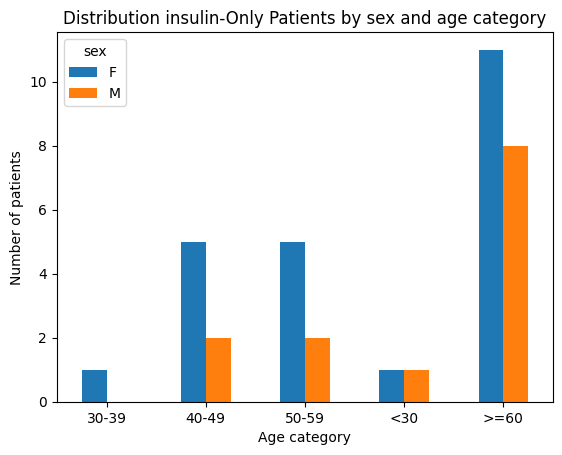

In [63]:
#group data
plot_data = insulin_only.groupby(["age_category", "sex"]).size().unstack(fill_value=0)
plot_data

#plot data
plot_data.plot(kind="bar")
plt.title("Distribution insulin-Only Patients by sex and age category")
plt.xlabel("Age category")
plt.ylabel("Number of patients")
plt.xticks(rotation=0)
plt.show()
